In [1]:
import os
import nibabel as nib
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

In [2]:
#1. Prepare dataset
def prepare_dataset():
    path_markings = 'Data/oznaczenia.txt'
    path_dataset = 'Dataset'

    with open(path_markings, 'r') as file:
        lines = file.readlines()

    file_data = []
    for line in lines:
        file_data.append(line.strip().split("\t"))

    labels = []
    images = []

    for idx, (file_name, index1, index0) in enumerate(file_data):
        img_path = os.path.join('Data', file_name)
        ct_img = nib.load(img_path)
        ct_data = ct_img.get_fdata()

        for i in range(ct_data.shape[2]):
            label = 1 if i in range(int(index0), int(index1)+1) else 0
            images.append(ct_data[:, :, i])  # Append the 2D slice
            labels.append(label)

    # Convert to NumPy arrays and ensure the correct shape
    images_array = np.array(images).astype(np.float32)  # Ensure float32 for model input
    labels_array = np.array(labels).astype(np.int64)    # Ensure int64 for labels

    # Save as .npy files for easy loading later
    np.save(os.path.join(path_dataset, 'images.npy'), images_array)
    np.save(os.path.join(path_dataset, 'labels.npy'), labels_array)
  

In [3]:
# prepare_dataset()

In [4]:
#2. Prepare training data
path_dataset = 'Dataset'

# images_array = torch.load(os.path.join(path_dataset, 'images.pt'))
# labels_array = torch.load(os.path.join(path_dataset, 'labels.pt'))
images_array = np.load(os.path.join(path_dataset, 'images.npy'))
labels_array = np.load(os.path.join(path_dataset, 'labels.npy'))

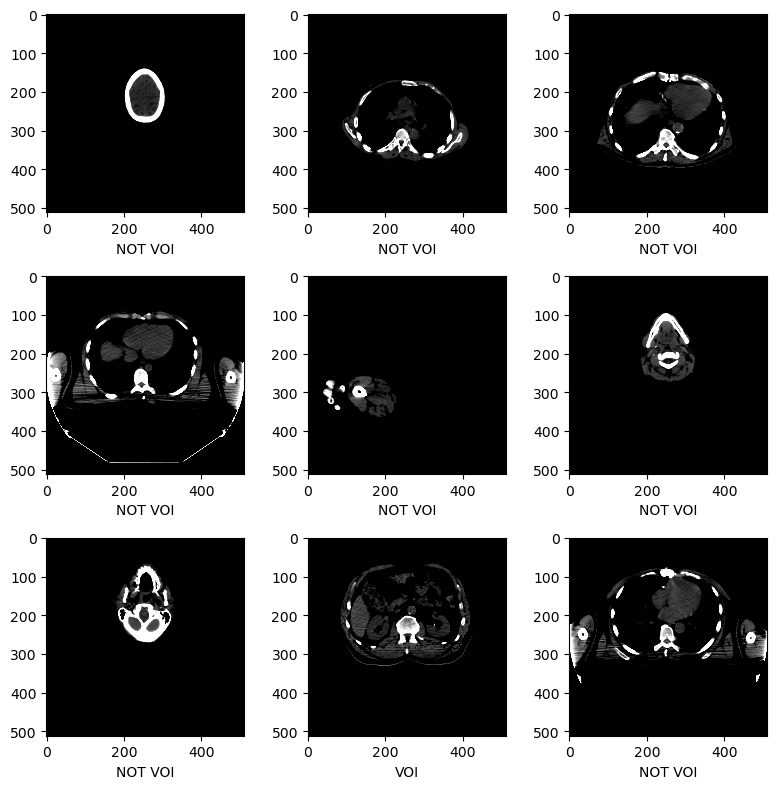

In [5]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(images_array), size=9)):
    im = images_array[k]
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(f"{'VOI' if labels_array[k] == 1 else 'NOT VOI'}")
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [6]:
val_frac = 0.1
test_frac = 0.1
length = len(images_array)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [images_array[i] for i in train_indices]
train_y = [labels_array[i] for i in train_indices]

val_x = [images_array[i] for i in val_indices]
val_y = [labels_array[i] for i in val_indices]

test_x = [images_array[i] for i in test_indices]
test_y = [labels_array[i] for i in test_indices]

print(f"Training size: {len(train_x)}\nValidation size: {len(val_x)}\nTest size: {len(test_x)}")

Training size: 3889
Validation size: 486
Test size: 486


In [7]:
num_class = 2

# train_x = [torch.tensor(image) for image in train_x]  # Convert to tensor
# val_x = [torch.tensor(image) for image in val_x]      # Convert to tensor
# test_x = [torch.tensor(image) for image in test_x]    # Convert to tensor
train_x = [torch.tensor(image).unsqueeze(0) for image in train_x]  # Add channel dimension
val_x = [torch.tensor(image).unsqueeze(0) for image in val_x]      # Add channel dimension
test_x = [torch.tensor(image).unsqueeze(0) for image in test_x]    # Add channel dimension
# train_transforms = Compose(
#     [
#         LoadImage(image_only=True),
#         EnsureChannelFirst(),
#         ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#         # RandFlip(spatial_axis=0, prob=0.5),
#         RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
#     ]
# )

# val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels):
        self.image_files = image_files
        self.labels = labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.image_files[index], self.labels[index]


train_ds = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# val_x = val_x[:5]
# val_y = val_y[:5]
val_ds = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_ds, batch_size=16)

test_ds = CustomDataset(test_x, test_y)
test_loader = DataLoader(test_ds, batch_size=16)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [10]:
# for batch in train_loader:
#     inputs, labels = batch[0], batch[1]
#     print(inputs.shape)

In [11]:
print(len(val_ds))

486


In [12]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
# writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        # epoch_len = len(train_ds) // train_loader.batch_size
        # writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for i, val_data in enumerate(val_loader):
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                print(f"Concatenating validation data {i+1}/{len(val_ds)}")
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            # y_onehot = y_trans(y)
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            # y_pred_act = y_pred_trans(y_pred)
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            # writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
    torch.cuda.empty_cache()

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
# writer.close()



----------
epoch 1/4
1/243, train_loss: 0.5612
2/243, train_loss: 0.5133
3/243, train_loss: 0.5893
4/243, train_loss: 0.5230
5/243, train_loss: 0.5740
6/243, train_loss: 0.5188
7/243, train_loss: 0.5363
8/243, train_loss: 0.5676
9/243, train_loss: 0.5650
10/243, train_loss: 0.5133
11/243, train_loss: 0.5140
12/243, train_loss: 0.4115
13/243, train_loss: 0.5249
14/243, train_loss: 0.5006
15/243, train_loss: 0.4395
16/243, train_loss: 0.5402
17/243, train_loss: 0.4603
18/243, train_loss: 0.5813
19/243, train_loss: 0.4097
20/243, train_loss: 0.4780
21/243, train_loss: 0.3755
22/243, train_loss: 0.4162
23/243, train_loss: 0.4439
24/243, train_loss: 0.4207
25/243, train_loss: 0.3865
26/243, train_loss: 0.3899
27/243, train_loss: 0.4565
28/243, train_loss: 0.4089
29/243, train_loss: 0.4775
30/243, train_loss: 0.3975
31/243, train_loss: 0.4141
32/243, train_loss: 0.3345
33/243, train_loss: 0.3520
34/243, train_loss: 0.3534
35/243, train_loss: 0.3887
36/243, train_loss: 0.3050
37/243, train_lo

KeyboardInterrupt: 